In [1]:
!pip install z3-solver
!pip install XlsxWriter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
from google.colab import files
from z3 import *
import matplotlib.pyplot as plt
import numpy as np
import itertools
import xlsxwriter
import random

In [4]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
INSTANCE_PATH = '/content/gdrive/MyDrive/SAT/instances/'
RESULT_PATH = "/content/gdrive/MyDrive/SAT/SAT_Res/"

In [6]:
def read_instance(n):
    with open(INSTANCE_PATH + 'ins-' + str(n) + '.txt') as f:
        contents = f.read()

    contents = contents.splitlines()
    # Extract the weight and number of circuits from the first two lines
    W = int(contents[0])
    N = int(contents[1])
    circuits = []

    # Iterate through the circuit lines and parse the data
    for i in range(2, N + 2):
        circuits.append([int(x) for x in contents[i].split()])

    return {'W': W, 'N': N, 'circuits': circuits}

In [7]:
def write_results(num_instance, w, h, n, widths, heights, corners_x, corners_y, rotation = False, rotated = []):
    path =''
    if rotation:
      path = RESULT_PATH + 'sol-rot-' + str(num_instance) + '.txt'
    else:
      path = RESULT_PATH + 'sol-' + str(num_instance) + '.txt'

    with open(path, 'w') as f:
        f.write(str(w) + " " + str(h) + "\n")
        f.write(str(n) + '\n')
        for i in range(n):
            if rotation and rotated[i]:
               f.write(str(heights[i]) + " " + str(widths[i]) + " "
                    +  str(corners_x[i]) + " " + str(corners_y[i]) + "\n")
            else:
              f.write(str(widths[i]) + " " + str(heights[i]) + " "
                      +  str(corners_x[i]) + " " + str(corners_y[i]) + "\n")
    f.close()

In [8]:
def show_results(num_instance, rotation=False, rotated=None):
    path = ''
    if rotation:
        path = RESULT_PATH  + 'sol-rot-' + str(num_instance) + '.txt'
    else:
        path = RESULT_PATH  + 'sol-' + str(num_instance) + '.txt'

    # Open the specified file for reading
    with open(path) as f:
        contents = f.read()

    # Split the file contents into lines
    contents = contents.splitlines()

    # Extract width (W), height (H), and the number of items (N) from the first two lines
    W, H = map(int, contents[0].split())
    N = int(contents[1])

    # Initialize lists to store item properties
    m = []  # Widths
    n = []  # Heights
    X = []  # X-coordinates of corners
    Y = []  # Y-coordinates of corners

    # Extract item properties for each item
    for k in range(2, N + 2):
        width, height, x, y = map(int, contents[k].split())
        m.append(width)
        n.append(height)
        X.append(x)
        Y.append(y)

    # Create a title for the plot based on rotation
    title = 'Solution instance ' + str(num_instance)
    if rotation:
        title += ' with rotation'

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    ax.set_title(title)

    # Define a list of random colors for item visualization
    random_color_list = ['#BFCCB5', '#7C96AB', '#B7B7B7', '#EDC6B1', '#FDF4F5',
                         '#E8A0BF', '#BA90C6', '#C0DBEA', '#DDFFBB', '#C7E9B0',
                         '#B3C99C', '#A4BC92', '#B2A4FF', '#FFB4B4', '#FFDEB4',
                         '#FDF7C3', '#FFF2CC', '#FFD966', '#F4B183', '#DFA67B',
                         '#867070', '#D5B4B4', '#E4D0D0', '#F5EBEB', '#BBD6B8',
                         '#AEC2B6', '#94AF9F', '#DBE4C6', '#CCD5AE', '#E9EDC9',
                         '#FEFAE0', '#FAEDCD', '#804674', '#A86464', '#B3E5BE',
                         '#F5FFC9', '#F7C8E0', '#DFFFD8', '#B4E4FF', '#95BDFF',
                         '#B9F3E4', '#EA8FEA', '#FFAACF', '#F6E6C2', '#B5F1CC',
                         '#6096B4', '#93BFCF', '#BDCDD6', '#EEE9DA', '#65647C',
                         '#8B7E74', '#C7BCA1', '#F1D3B3', '#FEBE8C', '#ECC5FB']

    # Visualize each item as a rectangle
    for i in range(N):
        random_color = random.choice(random_color_list)
        random_color_list.remove(random_color)

        # Create a rectangle patch for the item
        rect = plt.Rectangle((X[i], Y[i]), m[i], n[i], facecolor=random_color, edgecolor='black', linestyle='solid', linewidth=1.5)
        ax.add_patch(rect)

        # If rotation is allowed and the item is rotated, add a circle to represent rotation
        if rotation and rotated and rotated[i]:
            circle = plt.Circle((X[i] + m[i] / 2, Y[i] + n[i] / 2), 0.20, color='w', zorder=10)
            ax.add_patch(circle)

    # Set axis limits and equal aspect ratio
    ax.set(xlim=(0, W), ylim=(0, H))
    ax.set_aspect('equal')

    # Add a grid to the plot
    ax.grid(color='black', linewidth=0.75, linestyle='--')

    # Customize tick marks
    plt.xticks(np.arange(0, W + 1, 1), rotation=90)
    plt.yticks(np.arange(0, H + 1, 1))

    # Define the file path for saving the plot
    img_path = ''
    if rotation:
        img_path = RESULT_PATH + 'img/sol-rot-' + str(num_instance) + '.png'
    else:
        img_path = RESULT_PATH + 'img/sol-' + str(num_instance) + '.png'

    # Save the plot as an image and display it
    plt.savefig(img_path)
    plt.show()
    plt.close()

In [9]:
"""Absolute value function for Z3 solver, order by area function for block"""
def order_by_area(shape_matrix):
    n = len(shape_matrix[:, 0])
    for i in range(n - 1):
        for j in range(i + 1, n):
            if (shape_matrix[i, 0] * shape_matrix[i, 1]) < (shape_matrix[j, 0] * shape_matrix[j, 1]):
                tmp = np.copy(shape_matrix[i])
                shape_matrix[i] = np.copy(shape_matrix[j])
                shape_matrix[j] = np.copy(tmp)

    return shape_matrix

In [10]:
def get_lower_bound(instance, rotation=False):
    # Extract width, number of items, and item matrix from the instance
    W = instance['W']
    N = instance['N']
    shape_matrix = instance['circuits']

    # Initialize the minimum height requirement to 0
    min_height = 0

    # Calculate the total area of all items
    for k in range(N):
        min_height += shape_matrix[k][0] * shape_matrix[k][1]

    # Calculate the minimum height required, rounding up to the nearest integer
    min_height = np.ceil(min_height / W)

    if rotation:
        # Calculate the minimum between the maximum item height and width
        min_dim = np.min([np.max(shape_matrix[:, 1]), np.max(shape_matrix[:, 0])])
        return int(np.max([min_height, min_dim]))
    else:
        # Calculate the maximum between the minimum height and the maximum item height
        return int(np.max([min_height, np.max(shape_matrix[:, 1])]))

In [11]:
def get_upper_bound(instance):
    # Extract width, number of items, and item matrix from the instance
    W = instance['W']
    N = instance['N']
    shape_matrix = instance['circuits']

    # Initialize a list to store combination indexes
    combination_indexes = [0]

    # Initialize variables to track width sums
    width_sum = shape_matrix[0][0]
    width_sum_no_last = 0

    # Iterate through the items to find combination indexes
    for i in range(1, N):
        width_sum_no_last = width_sum
        width_sum += shape_matrix[i][0]

        # Check if a combination should end based on the modulo operation
        if ((width_sum - 1) % W) < ((width_sum_no_last - 1) % W):
            combination_indexes.append(i)

    combination_indexes.append(N - 1)

    max_h = 0

    # Calculate the maximum height for the combinations
    for i in range(len(combination_indexes) - 1):
        if combination_indexes[i] != combination_indexes[i + 1]:
            max_h += np.max(shape_matrix[combination_indexes[i]:combination_indexes[i + 1], 1])
        else:
            max_h += shape_matrix[combination_indexes[i], 1]

    return int(max_h)

In [12]:
def prepare_instance(instance_num):
    # Read the instance using the read_instance function
    instance = read_instance(instance_num)

    # Order the items within the instance based on their areas
    instance['circuits'] = order_by_area(np.asarray(instance['circuits']))

    # Return the modified instance
    return instance

In [ ]:
import xlsxwriter

def compute_statistics(rotation, symmetry_breaking, all_num_instances, all_solutions, all_is_optimal_solution, all_statistics, count):
    # Define the title for the Excel file based on parameters and count
    title = '/content/gdrive/MyDrive/SAT/' + str(count) + '-SAT_default'

    # Append parameters to the title to distinguish the file
    if rotation:
        title += '_With_rotation'
    else:
        title += '_no_rotation'

    if symmetry_breaking:
        title += '_with_symmetry_breaking'
    else:
        title += '_no_symmetry_breaking'

    # Add the file extension for Excel
    title += '.xlsx'

    # Print the title for debugging or information
    print(title)

    # Create an Excel workbook and worksheet
    workbook = xlsxwriter.Workbook(title)
    worksheet = workbook.add_worksheet()

    # Define cell formats for bold and red background
    bold_format = workbook.add_format({'bold': True})
    cell_format_red_bg = workbook.add_format({'bg_color': 'red'})

    # Write data headers to the Excel worksheet
    worksheet.write('A1', 'Instance', bold_format)
    worksheet.write('B1', 'Time', bold_format)
    worksheet.write('C1', 'Best solution', bold_format)

    # Start writing data from row 2
    start_row = 1

    # Iterate through all instances and populate the worksheet
    for i in range(len(all_num_instances)):
        worksheet.write(start_row + i, 0, all_num_instances[i])

        if all_is_optimal_solution[i]:
            # If the solution is optimal, write the time and best solution
            time = round(all_statistics[i].get_key_value('time'), 3)
            worksheet.write(start_row + i, 1, time)
            worksheet.write(start_row + i, 2, all_solutions[i])
        else:
            # If it's not optimal, mark as "Timeout" and apply red background
            worksheet.write(start_row + i, 1, 'Timeout', cell_format_red_bg)
            worksheet.write(start_row + i, 4, all_solutions[i], cell_format_red_bg)

    # Close the Excel workbook
    workbook.close()


In [ ]:
def SAT_encoding(instance, H, symmetry_breaking=False):
    W = instance['W']
    m = instance['circuits'][:, 0]
    n = instance['circuits'][:, 1]
    N = instance['N']

    g = Goal()

    # Define variables for order encoding
    px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(N)]
    py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(N)]

    # Define variables for relative positions (left and under)
    under = [[Bool(f"ud_{i+1}_{j+1}") if i != j else 0 for j in range(N)] for i in range(N)]
    left = [[Bool(f"lt{i+1}_{j+1}") if j != i else 0 for j in range(N)] for i in range(N)]

    # Constraints ensuring non-overlapping of blocks
    for i in range(N):
        for j in range(i + 1, N):
            g.add(Or(left[i][j], left[j][i], under[i][j], under[j][i]))

    # Clauses due to order encoding
    for i in range(N):
        for e in range(0, W - m[i]):
            g.add(Or(Not(px[i][e]), px[i][e + 1]))

        for f in range(0, H - n[i]):
            g.add(Or(Not(py[i][f]), py[i][f + 1]))

        for e in range(W - m[i], W):
            g.add(px[i][e])

        for f in range(H - n[i], H):
            g.add(py[i][f])

    # Relative position constraints between blocks
    for i in range(N):
        for j in range(N):
            if i != j:
                # left(i,j) -> xj > wi, lower bound for xj
                g.add(Or(Not(left[i][j]), Not(px[j][m[i] - 1])))
                # under(ri,rj)-> yj > hi, lower bound for yj
                g.add(Or(Not(under[i][j]), Not(py[j][n[i] - 1])))

                # 3-literals clauses for non-overlapping, as shown in the paper
                for e in range(0, W - m[i]):
                    g.add(Or(Not(left[i][j]), px[i][e], Not(px[j][e + m[i]])))
                for e in range(0, W - m[j]):
                    g.add(Or(Not(left[j][i]), px[j][e], Not(px[i][e + m[j]])))

                for f in range(0, H - n[i]):
                    g.add(Or(Not(under[i][j]), py[i][f], Not(py[j][f + n[i]])))
                for f in range(0, H - n[j]):
                    g.add(Or(Not(under[j][i]), py[j][f], Not(py[i][f + n[j]])))

    if symmetry_breaking:
        # Apply symmetry-breaking constraints if specified
        g.add(And(use_symmetry_breaking(N, W, H, m, n, px, py, left, under)))

    return g


In [ ]:
import itertools

def use_symmetry_breaking(N, W, H, m, n, px, py, left, under):
    domain_reduction_constraint = []

    # Domain reduction constraint for the first rectangle
    for i in range(int(np.floor((W - m[0]) / 2))):
        domain_reduction_constraint.append(Not(px[0][i]))

    for j in range(int(np.floor((H - n[0]) / 2))):
        domain_reduction_constraint.append(Not(py[0][j]))

    # Additional domain reduction constraints for other rectangles
    for rect in range(1, N):
        if m[rect] > np.ceil((W - m[0]) / 2):
            domain_reduction_constraint.append(Not(left[0][rect]))
        if n[rect] > np.ceil((H - n[0]) / 2):
            domain_reduction_constraint.append(Not(under[0][rect]))

    # Symmetry-breaking constraints for rectangles of the same size
    for (i, j) in itertools.combinations(range(N), 2):
        if m[i] == m[j] and n[i] == n[j]:
            domain_reduction_constraint.append(Not(left[j][i]))
            domain_reduction_constraint.append(Or(Not(under[j][i]), left[i][j]))

    return domain_reduction_constraint


In [ ]:
import itertools

def SAT_encoding_rotation(instance, H, symmetry_breaking=False):
    # Renaming variables for consistency with replacements
    W = instance['W']
    m = instance['circuits'][:, 0]
    n = instance['circuits'][:, 1]
    N = instance['N']

    g = Goal()

    # Decision variables to encode block placement
    px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(N)]
    py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(N)]

    # Matrices to represent block relationships (left and under)
    under = [[Bool(f"ud_{i+1}_{j+1}") if i != j else 0 for j in range(N)] for i in range(N)]
    left = [[Bool(f"lt{i+1}_{j+1}") if j != i else 0 for j in range(N)] for i in range(N)]

    # Indicator variable for block rotation
    rotated = [Bool(f"r_{i+1}") for i in range(N)]

    # Encoding non-overlapping constraints
    for i in range(N):
        if n[i] <= W:
            g.add(Or(And(Not(rotated[i]), *[Or(Not(px[i][e]), px[i][e+1]) for e in range(0, W - m[i])]),
                     And(rotated[i], *[Or(Not(px[i][e]), px[i][e+1]) for e in range(0, W - n[i])])))

            g.add(Or(And(Not(rotated[i]), *[Or(Not(py[i][f]), py[i][f+1]) for f in range(0, H - n[i])]),
                     And(rotated[i], *[Or(Not(py[i][f]), py[i][f+1]) for f in range(0, H - m[i])])))

            g.add(Or(And(Not(rotated[i]), *[px[i][e] for e in range(W - m[i], W)]),
                     And(rotated[i], *[px[i][e] for e in range(W - n[i], W)])))

            g.add(Or(And(Not(rotated[i]), *[py[i][f] for f in range(H - n[i], H)]),
                     And(rotated[i], *[py[i][f] for f in range(H - m[i], H)])))
        else:
            g.add(Not(rotated[i]))
            g.add(*[Or(Not(px[i][e]), px[i][e+1]) for e in range(0, W - m[i])])
            g.add(*[Or(Not(py[i][f], py[i][f+1])) for f in range(0, H - n[i])])

            g.add(*[px[i][e] for e in range(W - m[i], W)])
            g.add(*[py[i][f] for f in range(H - n[i], H)])

    # Constraints based on block properties and rotations
    g.add([Not(rotated[i]) for i in range(N) if m[i] == n[i]])
    g.add([Not(rotated[i]) for i in range(N) if n[i] > W])
    g.add([Not(rotated[i]) for i in range(N) if m[i] > H])

    # Overlapping constraints between blocks
    for i in range(N):
        for j in range(N):
            if i != j:
                if n[i] <= W:
                    g.add(Or(And(Not(rotated[i]), Or(Not(left[i][j]), Not(px[j][m[i]-1]))),
                             And(rotated[i], Or(Not(left[i][j]), Not(px[j][n[i]-1])))))

                    g.add(Or(And(Not(rotated[i]), Or(Not(under[i][j]), Not(py[j][n[i]-1]))),
                             And(rotated[i], Or(Not(under[i][j]), Not(py[j][m[i]-1])))))

                    g.add(Or(And(Not(rotated[i]), *[Or(Not(left[i][j]), px[i][e], Not(px[j][e+m[i]])) for e in range(0, W - m[i])]),
                             And(rotated[i], *[Or(Not(left[i][j]), px[i][e], Not(px[j][e+n[i]])) for e in range(0, W - n[i])])))

                    g.add(Or(And(Not(rotated[j]), *[Or(Not(left[j][i]), px[j][e], Not(px[i][e+m[j]])) for e in range(0, W - m[j])]),
                             And(rotated[j], *[Or(Not(left[j][i]), px[j][e], Not(px[i][e+n[j]])) for e in range(0, W - n[j])])))

                    g.add(Or(And(Not(rotated[i]), *[Or(Not(under[i][j]), py[i][f], Not(py[j][f+n[i]])) for f in range(0, H - n[i])]),
                             And(rotated[i], *[Or(Not(under[i][j]), py[i][f], Not(py[j][f+m[i]])) for f in range(0, H - m[i])])))

                    g.add(Or(And(Not(rotated[j]), *[Or(Not(under[j][i]), py[j][f], Not(py[i][f+n[j]])) for f in range(0, H - n[j])]),
                             And(rotated[j], *[Or(Not(under[j][i]), py[j][f], Not(py[i][f+m[j]])) for f in range(0, H - m[j])])))
                else:
                    g.add(Or(Not(left[i][j]), Not(px[j][m[i]-1])))
                    g.add(Or(Not(under[i][j]), Not(py[j][n[i]-1])))
                    g.add(*[Or(Not(left[i][j]), px[i][e], Not(px[j][e+m[i]])) for e in range(0, W - m[i])])
                    g.add(*[Or(Not(left[j][i]), px[j][e], Not(px[i][e+m[j]])) for e in range(0, W - m[j])])
                    g.add(*[Or(Not(under[i][j]), py[i][f], Not(py[j][f+n[i]])) for f in range(0, H - n[i])])
                    g.add(*[Or(Not(under[j][i]), py[j][f], Not(py[i][f+n[j]])) for f in range(0, H - n[j])])

    # Large rectangle constraints from the paper
    for (i, j) in itertools.combinations(range(N), 2):
        if m[i] + m[j] > W:
            g.add(Not(left[i][j]))  # Blocks i and j cannot be to the left of each other
            g.add(Not(left[j][i]))  # Symmetric constraint for left

        if n[i] + n[j] > H:
            g.add(Not(under[i][j]))  # Blocks i and j cannot be under each other
            g.add(Not(under[j][i]))  # Symmetric constraint for under

    if symmetry_breaking:
        print('- add sb constraints')
        g.add(And(use_symmetry_breaking_rotation(N, W, H, m, n, px, py, left, under, rotated)))  # Adding symmetry-breaking constraints

    return g

In [ ]:
def use_symmetry_breaking_rotation(N, W, H, m, n, px, py, left, under, rotated):
    domain_reduction_constraint = []
    # Domain reduction constraint

    if n[0] <= W:
        # If the first block's height is less than or equal to the plate's width
        domain_reduction_constraint.append(
            Or(
                # If the first block is rotated
                And(rotated[0], *[Not(px[0][i]) for i in range(int(np.floor((W - n[0]) / 2)))]),
                # If the first block is not rotated
                And(Not(rotated[0]), *[Not(px[0][i]) for i in range(int(np.floor((W - m[0]) / 2)))])
            )
        )

        domain_reduction_constraint.append(
            Or(
                # If the first block is rotated
                And(rotated[0], *[Not(py[0][j]) for j in range(int(np.floor((H - m[0]) / 2)))]),
                # If the first block is not rotated
                And(Not(rotated[0]), *[Not(py[0][j]) for j in range(int(np.floor((H - n[0]) / 2)))])
            )
        )
    else:
        # If the first block's height is greater than the plate's width
        domain_reduction_constraint.append(
            And(*[Not(px[0][i]) for i in range(int(np.floor((W - m[0]) / 2)))]))
        domain_reduction_constraint.append(
            And(*[Not(py[0][j]) for j in range(int(np.floor((H - n[0]) / 2)))]))

    return domain_reduction_constraint


In [ ]:
def SAT_check(sat_encoding, time_limit=None):
    # Define tactics for solving
    t = Then(
        Repeat(With(Tactic('simplify'), cache_all=True)),
        Repeat('propagate-values'),
        'symmetry-reduce',
        'sat-preprocess'
    )

    theory_solver = Tactic('psat')
    final_tactic = Then(t, theory_solver)

    # Create a solver instance
    s = final_tactic.solver()

    # Add SAT encoding to the solver
    s.add(sat_encoding)

    if time_limit is not None:
        print('Solver timeout:', time_limit, 's')
        s.set("timeout", int(time_limit * 1000))

    # Check if the problem is SAT or UNSAT
    if s.check() == sat:
        return True, s.model(), s.statistics()
    else:
        return False, None, s.statistics()


def converter_sat_coord(m, W, H, N, rotation=False):
    # Define Boolean variables for x and y coordinates
    px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(N)]
    py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(N)]

    # Boolean variables for rotated state
    rotated_vars = [Bool(f"r_{i+1}") for i in range(N)]
    rotated = []

    x_sol = []  # List to store x-coordinate solution
    y_sol = []  # List to store y-coordinate solution

    for i in range(N):
        if rotation:
            if m.evaluate(rotated_vars[i]) == True:
                rotated.append(True)
            else:
                rotated.append(False)

        j = 0
        while j < W:
            if m.evaluate(px[i][j]):
                x_sol.append(j)
                break
            j += 1

        j = 0
        while j < H:
            if m.evaluate(py[i][j]):
                y_sol.append(j)
                break
            j += 1

    return x_sol, y_sol, rotated

In [ ]:
def solve_instances(instance_num, time_limit=None, rotation=False, symmetry_breaking=False, verbose=False, count=0):
    all_num_instances = []
    all_solutions = []
    all_is_optimal_solution = []
    all_statistics = []

    for i in instance_num:
        print('\n***Instance num:', str(i), '***\n')

        all_num_instances.append(i)
        instance = prepare_instance(i)
        min_h = get_lower_bound(instance, rotation)
        max_h = get_upper_bound(instance)

        print('Plate width ->', instance['W'])  # Replaced w with W
        print('Min h ->', min_h)
        print('Max h ->', max_h)

        count_attempt = 1
        test_h = min_h
        model = None
        statistics = None
        time = 0

        while min_h <= test_h and test_h <= max_h:
            print('\n- Attempt num ->', count_attempt)
            print(' - Tested h ->', test_h)

            if rotation:
                print('- rotation enabled')
                encoding = SAT_encoding_rotation(instance, test_h, symmetry_breaking)
            else:
                encoding = SAT_encoding(instance, test_h, symmetry_breaking)

            if time_limit is not None:
                is_sat, model_tmp, statistics_tmp = SAT_check(encoding, time_limit - time)
            else:
                is_sat, model_tmp, statistics_tmp = SAT_check(encoding, None)

            time_tmp = statistics_tmp.get_key_value('time')
            time += time_tmp

            print('Expired time for this attempt ->', time_tmp, 's')
            if is_sat != True:
                print('**UNSAT**')
                test_h += 1
            else:
                print('**SAT**')
                model = model_tmp
                statistics = statistics_tmp
                break

            count_attempt += 1

            if time_limit is not None and time >= time_limit:
                break

        if (time_limit is None or time <= time_limit) and model is not None:
            print('Optimal solution founded in', round(time, 3), 's, h ->', test_h)

            all_is_optimal_solution.append(True)
            all_solutions.append(test_h)

            if verbose and statistics is not None:
                print('Statistics from z3 solver')
                print(statistics)

            all_statistics.append(statistics)

            corner_x, corner_y, rotated = converter_sat_coord(model, instance['W'], test_h, instance['N'], rotation)
            write_results(i,instance['W'],test_h,instance['N'],instance['circuits'][:,0],instance['circuits'][:,1],corner_x,corner_y, rotation, rotated)
            show_results(i, rotation, rotated)

        else:
            print('No optimal solution in', str(time_limit), 's founded')
            all_is_optimal_solution.append(False)

            if model is not None:
                print('Last suboptimal solution')

                if verbose and statistics is not None:
                    print('Statistics from z3 solver')
                    print(statistics)

                all_statistics.append(statistics)
                all_solutions.append(test_h)
                corner_x, corner_y, rotated = converter_sat_coord(model, instance['W'], test_h, instance['N'], rotation)
                write_results(i,instance['W'],test_h,instance['N'],instance['circuits'][:,0],instance['circuits'][:,1],corner_x,corner_y, rotation, rotated)
                show_results(i, rotation, rotated)
            else:
                all_statistics.append(None)
                all_solutions.append(0)

    compute_statistics(rotation, symmetry_breaking, all_num_instances, all_solutions, all_is_optimal_solution, all_statistics, count)

In [23]:
time_limit = 300
instance_num =np.linspace(1, 40, dtype=int)


***Instance num: 1 ***

Plate width -> 8
Min h -> 8
Max h -> 10

- Attempt num -> 1
 - Tested h -> 8
Solver timeout: 300 s
Expired time for this attempt -> 1.309 s
**SAT**
Optimal solution founded in 1.309 s, h -> 8


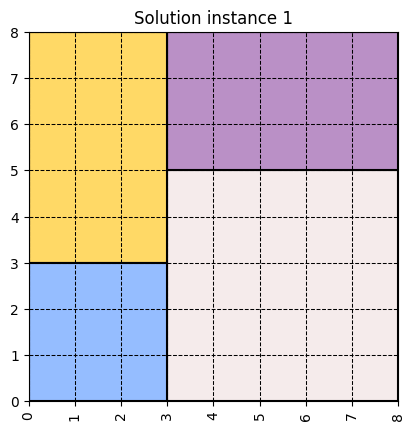


***Instance num: 1 ***

Plate width -> 8
Min h -> 8
Max h -> 10

- Attempt num -> 1
 - Tested h -> 8
Solver timeout: 300 s
Expired time for this attempt -> 1.187 s
**SAT**
Optimal solution founded in 1.187 s, h -> 8


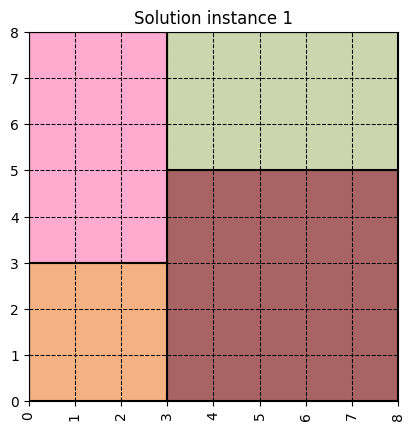


***Instance num: 2 ***

Plate width -> 9
Min h -> 9
Max h -> 13

- Attempt num -> 1
 - Tested h -> 9
Solver timeout: 300 s
Expired time for this attempt -> 1.24 s
**SAT**
Optimal solution founded in 1.24 s, h -> 9


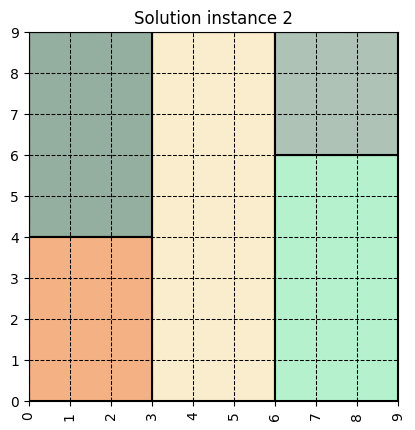


***Instance num: 3 ***

Plate width -> 10
Min h -> 10
Max h -> 11

- Attempt num -> 1
 - Tested h -> 10
Solver timeout: 300 s
Expired time for this attempt -> 1.119 s
**SAT**
Optimal solution founded in 1.119 s, h -> 10


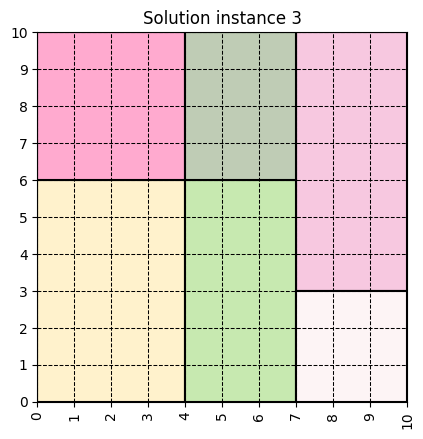


***Instance num: 4 ***

Plate width -> 11
Min h -> 11
Max h -> 14

- Attempt num -> 1
 - Tested h -> 11
Solver timeout: 300 s
Expired time for this attempt -> 1.076 s
**SAT**
Optimal solution founded in 1.076 s, h -> 11


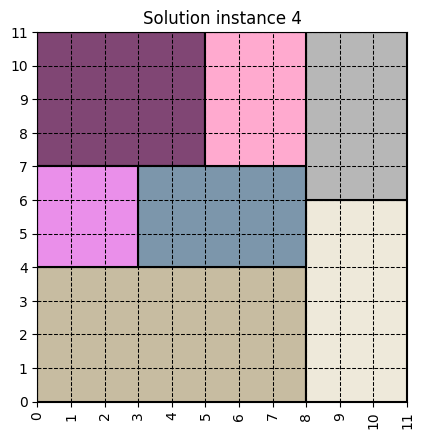


***Instance num: 4 ***

Plate width -> 11
Min h -> 11
Max h -> 14

- Attempt num -> 1
 - Tested h -> 11
Solver timeout: 300 s
Expired time for this attempt -> 1.099 s
**SAT**
Optimal solution founded in 1.099 s, h -> 11


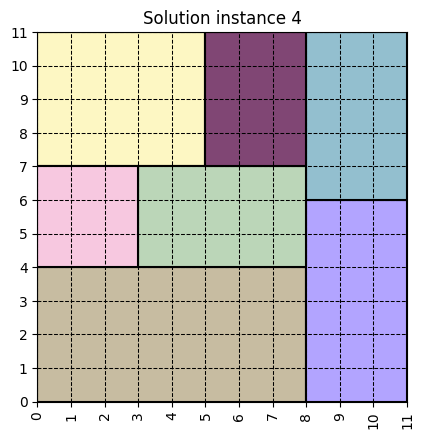


***Instance num: 5 ***

Plate width -> 12
Min h -> 12
Max h -> 17

- Attempt num -> 1
 - Tested h -> 12
Solver timeout: 300 s
Expired time for this attempt -> 1.075 s
**SAT**
Optimal solution founded in 1.075 s, h -> 12


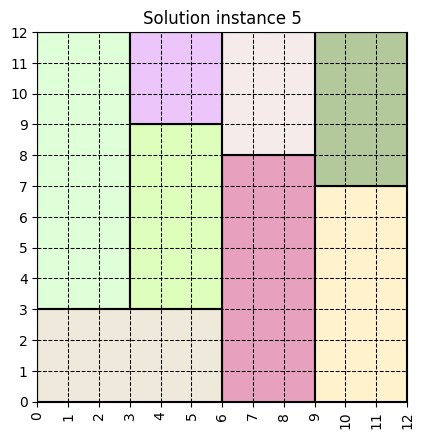


***Instance num: 6 ***

Plate width -> 13
Min h -> 13
Max h -> 17

- Attempt num -> 1
 - Tested h -> 13
Solver timeout: 300 s
Expired time for this attempt -> 1.102 s
**SAT**
Optimal solution founded in 1.102 s, h -> 13


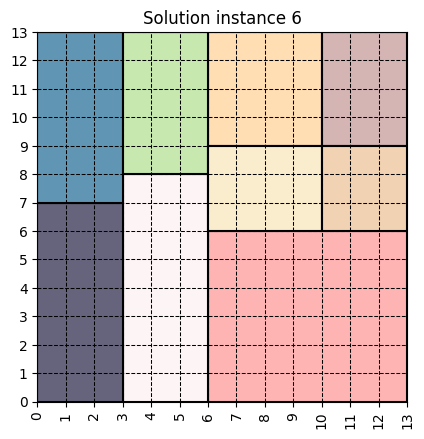


***Instance num: 7 ***

Plate width -> 14
Min h -> 14
Max h -> 19

- Attempt num -> 1
 - Tested h -> 14
Solver timeout: 300 s
Expired time for this attempt -> 1.179 s
**SAT**
Optimal solution founded in 1.179 s, h -> 14


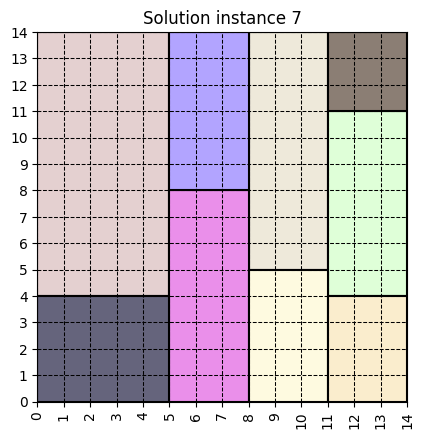


***Instance num: 8 ***

Plate width -> 15
Min h -> 15
Max h -> 24

- Attempt num -> 1
 - Tested h -> 15
Solver timeout: 300 s
Expired time for this attempt -> 1.31 s
**SAT**
Optimal solution founded in 1.31 s, h -> 15


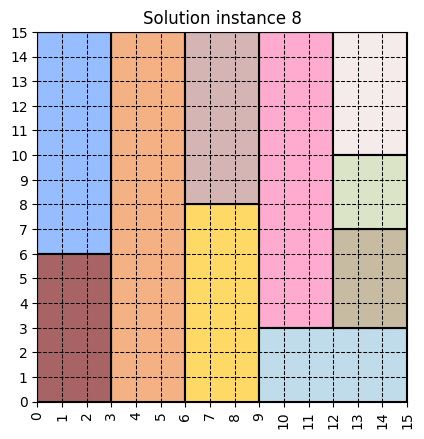


***Instance num: 8 ***

Plate width -> 15
Min h -> 15
Max h -> 24

- Attempt num -> 1
 - Tested h -> 15
Solver timeout: 300 s
Expired time for this attempt -> 1.088 s
**SAT**
Optimal solution founded in 1.088 s, h -> 15


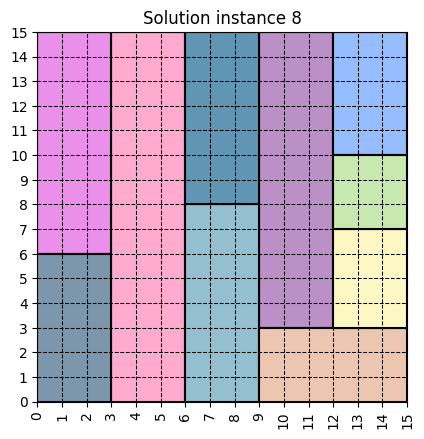


***Instance num: 9 ***

Plate width -> 16
Min h -> 16
Max h -> 23

- Attempt num -> 1
 - Tested h -> 16
Solver timeout: 300 s
Expired time for this attempt -> 1.106 s
**SAT**
Optimal solution founded in 1.106 s, h -> 16


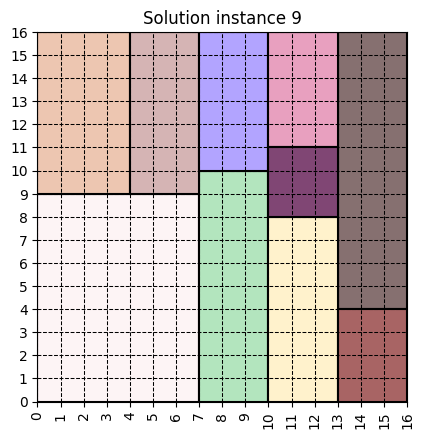


***Instance num: 10 ***

Plate width -> 17
Min h -> 17
Max h -> 28

- Attempt num -> 1
 - Tested h -> 17
Solver timeout: 300 s
Expired time for this attempt -> 1.141 s
**SAT**
Optimal solution founded in 1.141 s, h -> 17


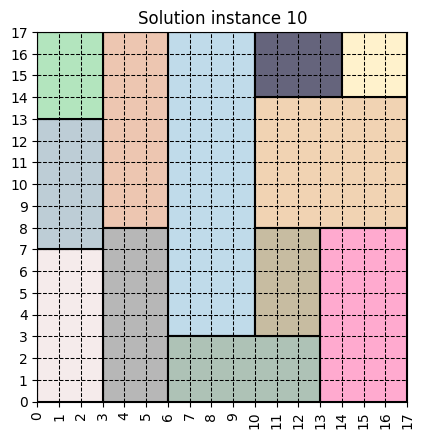


***Instance num: 11 ***

Plate width -> 18
Min h -> 18
Max h -> 29

- Attempt num -> 1
 - Tested h -> 18
Solver timeout: 300 s
Expired time for this attempt -> 9.082 s
**SAT**
Optimal solution founded in 9.082 s, h -> 18


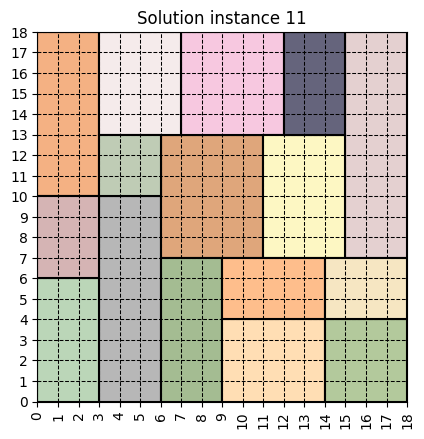


***Instance num: 12 ***

Plate width -> 19
Min h -> 19
Max h -> 32

- Attempt num -> 1
 - Tested h -> 19
Solver timeout: 300 s
Expired time for this attempt -> 1.659 s
**SAT**
Optimal solution founded in 1.659 s, h -> 19


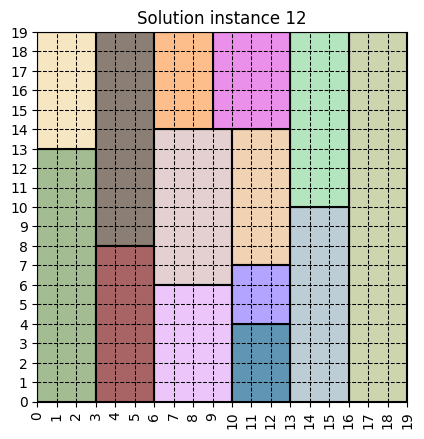


***Instance num: 12 ***

Plate width -> 19
Min h -> 19
Max h -> 32

- Attempt num -> 1
 - Tested h -> 19
Solver timeout: 300 s
Expired time for this attempt -> 1.403 s
**SAT**
Optimal solution founded in 1.403 s, h -> 19


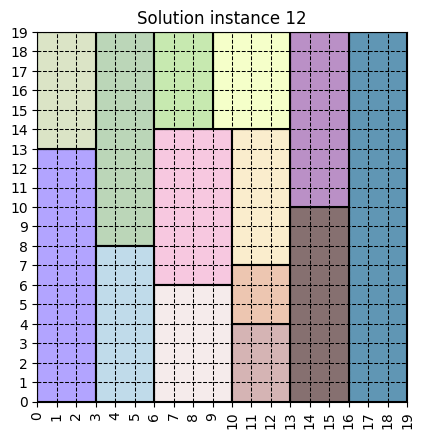


***Instance num: 13 ***

Plate width -> 20
Min h -> 20
Max h -> 31

- Attempt num -> 1
 - Tested h -> 20
Solver timeout: 300 s
Expired time for this attempt -> 1.145 s
**SAT**
Optimal solution founded in 1.145 s, h -> 20


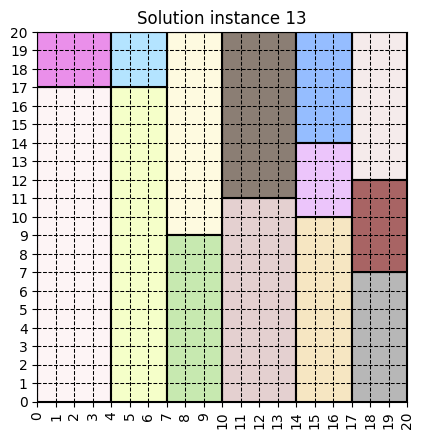


***Instance num: 14 ***

Plate width -> 21
Min h -> 21
Max h -> 33

- Attempt num -> 1
 - Tested h -> 21
Solver timeout: 300 s
Expired time for this attempt -> 2.079 s
**SAT**
Optimal solution founded in 2.079 s, h -> 21


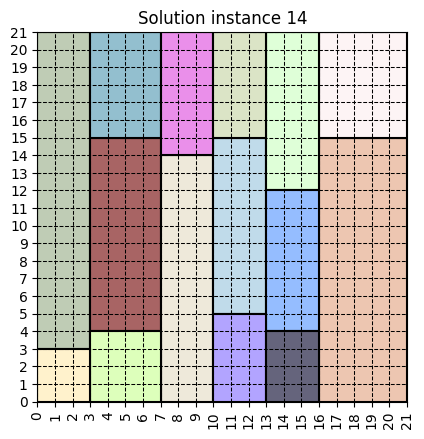


***Instance num: 15 ***

Plate width -> 22
Min h -> 22
Max h -> 35

- Attempt num -> 1
 - Tested h -> 22
Solver timeout: 300 s
Expired time for this attempt -> 1.164 s
**SAT**
Optimal solution founded in 1.164 s, h -> 22


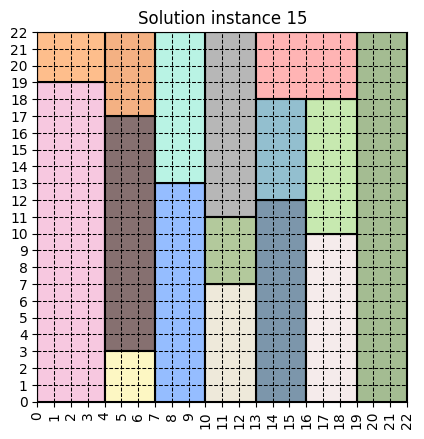


***Instance num: 16 ***

Plate width -> 23
Min h -> 23
Max h -> 36

- Attempt num -> 1
 - Tested h -> 23
Solver timeout: 300 s
Expired time for this attempt -> 13.831 s
**SAT**
Optimal solution founded in 13.831 s, h -> 23


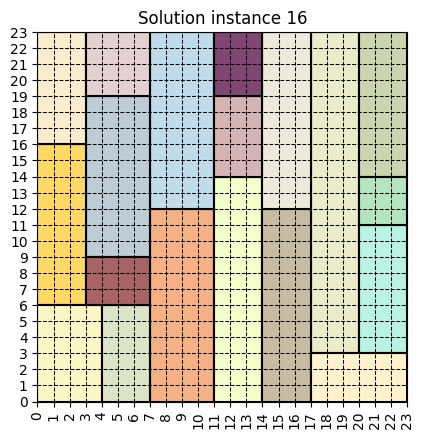


***Instance num: 16 ***

Plate width -> 23
Min h -> 23
Max h -> 36

- Attempt num -> 1
 - Tested h -> 23
Solver timeout: 300 s
Expired time for this attempt -> 14.504 s
**SAT**
Optimal solution founded in 14.504 s, h -> 23


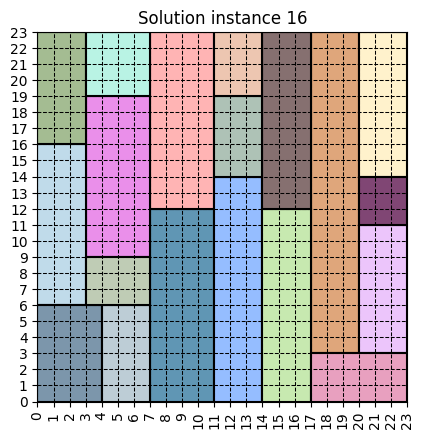


***Instance num: 17 ***

Plate width -> 24
Min h -> 24
Max h -> 41

- Attempt num -> 1
 - Tested h -> 24
Solver timeout: 300 s
Expired time for this attempt -> 1.648 s
**SAT**
Optimal solution founded in 1.648 s, h -> 24


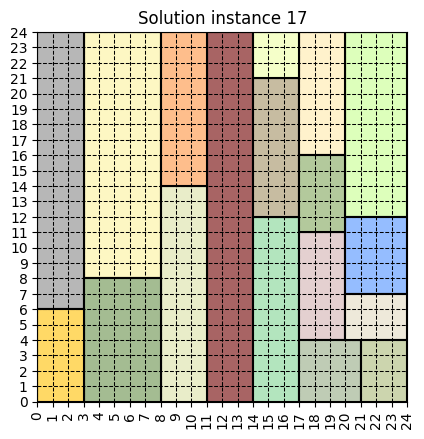


***Instance num: 18 ***

Plate width -> 25
Min h -> 25
Max h -> 40

- Attempt num -> 1
 - Tested h -> 25
Solver timeout: 300 s
Expired time for this attempt -> 2.155 s
**SAT**
Optimal solution founded in 2.155 s, h -> 25


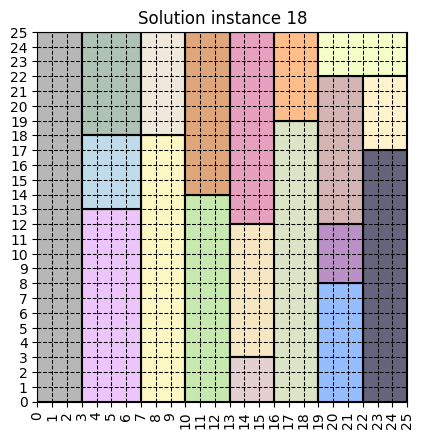


***Instance num: 19 ***

Plate width -> 26
Min h -> 26
Max h -> 36

- Attempt num -> 1
 - Tested h -> 26
Solver timeout: 300 s
Expired time for this attempt -> 3.944 s
**SAT**
Optimal solution founded in 3.944 s, h -> 26


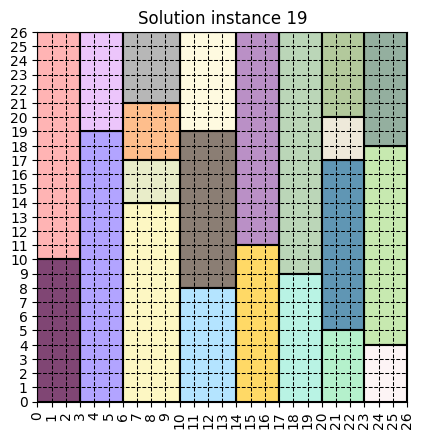


***Instance num: 20 ***

Plate width -> 27
Min h -> 27
Max h -> 36

- Attempt num -> 1
 - Tested h -> 27
Solver timeout: 300 s
Expired time for this attempt -> 10.89 s
**SAT**
Optimal solution founded in 10.89 s, h -> 27


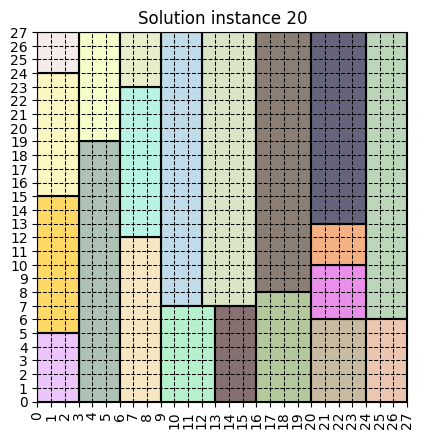


***Instance num: 20 ***

Plate width -> 27
Min h -> 27
Max h -> 36

- Attempt num -> 1
 - Tested h -> 27
Solver timeout: 300 s
Expired time for this attempt -> 10.197 s
**SAT**
Optimal solution founded in 10.197 s, h -> 27


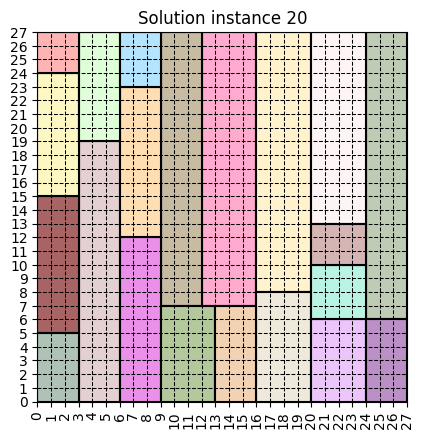


***Instance num: 21 ***

Plate width -> 28
Min h -> 28
Max h -> 40

- Attempt num -> 1
 - Tested h -> 28
Solver timeout: 300 s
Expired time for this attempt -> 8.96 s
**SAT**
Optimal solution founded in 8.96 s, h -> 28


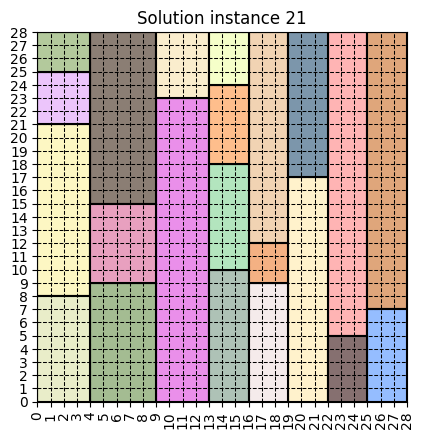


***Instance num: 22 ***

Plate width -> 29
Min h -> 29
Max h -> 37

- Attempt num -> 1
 - Tested h -> 29
Solver timeout: 300 s
Expired time for this attempt -> 28.318 s
**SAT**
Optimal solution founded in 28.318 s, h -> 29


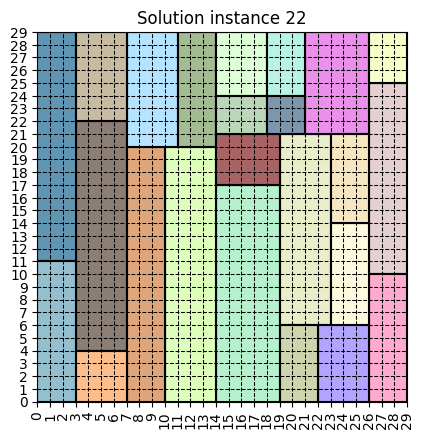


***Instance num: 23 ***

Plate width -> 30
Min h -> 30
Max h -> 46

- Attempt num -> 1
 - Tested h -> 30
Solver timeout: 300 s
Expired time for this attempt -> 12.472 s
**SAT**
Optimal solution founded in 12.472 s, h -> 30


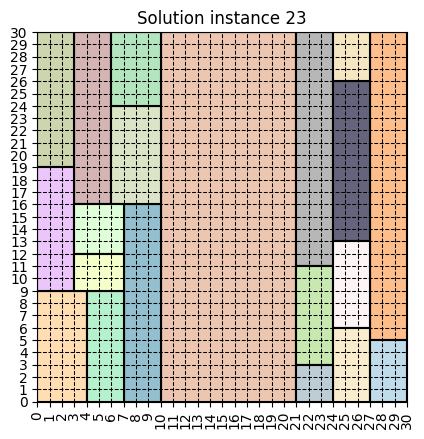


***Instance num: 24 ***

Plate width -> 31
Min h -> 31
Max h -> 46

- Attempt num -> 1
 - Tested h -> 31
Solver timeout: 300 s
Expired time for this attempt -> 1.937 s
**SAT**
Optimal solution founded in 1.937 s, h -> 31


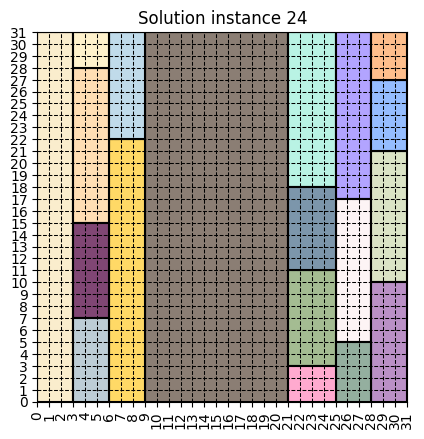


***Instance num: 24 ***

Plate width -> 31
Min h -> 31
Max h -> 46

- Attempt num -> 1
 - Tested h -> 31
Solver timeout: 300 s
Expired time for this attempt -> 2.083 s
**SAT**
Optimal solution founded in 2.083 s, h -> 31


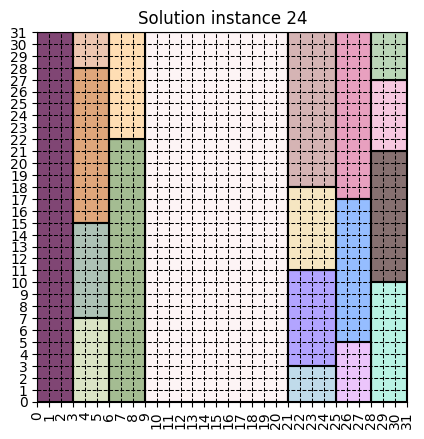


***Instance num: 25 ***

Plate width -> 32
Min h -> 32
Max h -> 47

- Attempt num -> 1
 - Tested h -> 32
Solver timeout: 300 s
Expired time for this attempt -> 12.285 s
**SAT**
Optimal solution founded in 12.285 s, h -> 32


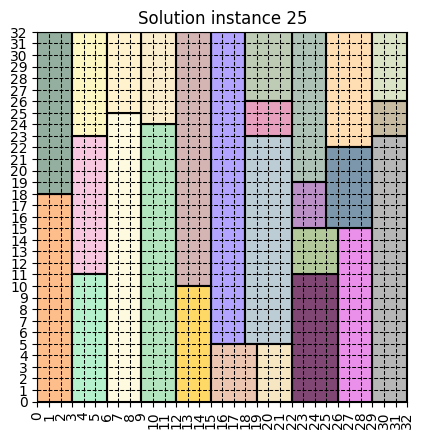


***Instance num: 26 ***

Plate width -> 33
Min h -> 33
Max h -> 53

- Attempt num -> 1
 - Tested h -> 33
Solver timeout: 300 s
Expired time for this attempt -> 2.921 s
**SAT**
Optimal solution founded in 2.921 s, h -> 33


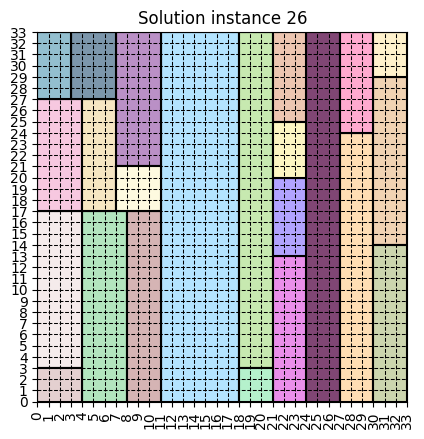


***Instance num: 27 ***

Plate width -> 34
Min h -> 34
Max h -> 53

- Attempt num -> 1
 - Tested h -> 34
Solver timeout: 300 s
Expired time for this attempt -> 12.379 s
**SAT**
Optimal solution founded in 12.379 s, h -> 34


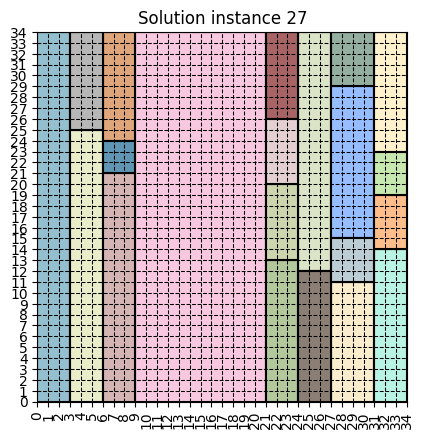


***Instance num: 28 ***

Plate width -> 35
Min h -> 35
Max h -> 52

- Attempt num -> 1
 - Tested h -> 35
Solver timeout: 300 s
Expired time for this attempt -> 2.032 s
**SAT**
Optimal solution founded in 2.032 s, h -> 35


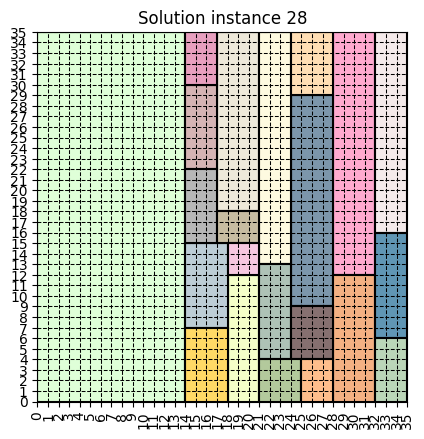


***Instance num: 28 ***

Plate width -> 35
Min h -> 35
Max h -> 52

- Attempt num -> 1
 - Tested h -> 35
Solver timeout: 300 s
Expired time for this attempt -> 2.088 s
**SAT**
Optimal solution founded in 2.088 s, h -> 35


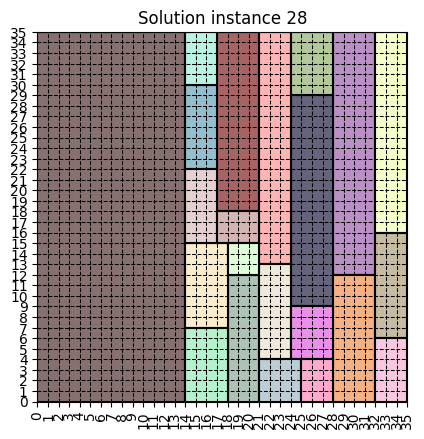


***Instance num: 29 ***

Plate width -> 36
Min h -> 36
Max h -> 56

- Attempt num -> 1
 - Tested h -> 36
Solver timeout: 300 s
Expired time for this attempt -> 10.649 s
**SAT**
Optimal solution founded in 10.649 s, h -> 36


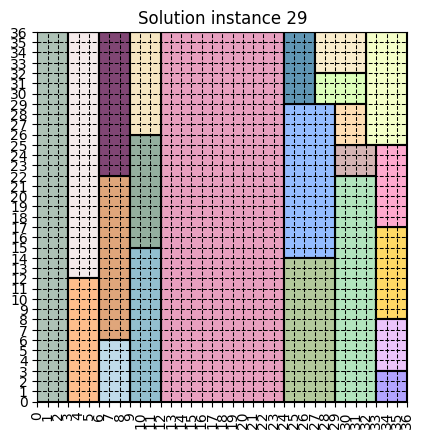


***Instance num: 30 ***

Plate width -> 37
Min h -> 37
Max h -> 57

- Attempt num -> 1
 - Tested h -> 37
Solver timeout: 300 s
Expired time for this attempt -> 300.004 s
**UNSAT**
No optimal solution in 300 s founded

***Instance num: 31 ***

Plate width -> 38
Min h -> 38
Max h -> 55

- Attempt num -> 1
 - Tested h -> 38
Solver timeout: 300 s
Expired time for this attempt -> 2.171 s
**SAT**
Optimal solution founded in 2.171 s, h -> 38


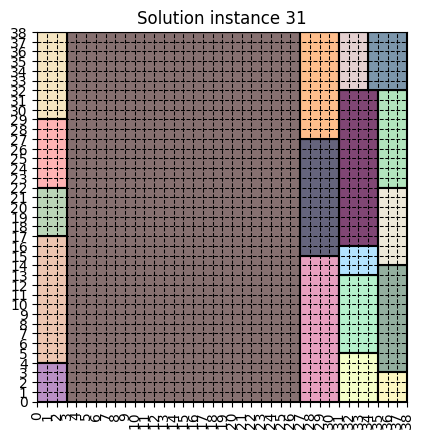


***Instance num: 32 ***

Plate width -> 39
Min h -> 39
Max h -> 66

- Attempt num -> 1
 - Tested h -> 39
Solver timeout: 300 s
Expired time for this attempt -> 300.023 s
**UNSAT**
No optimal solution in 300 s founded

***Instance num: 32 ***

Plate width -> 39
Min h -> 39
Max h -> 66

- Attempt num -> 1
 - Tested h -> 39
Solver timeout: 300 s
Expired time for this attempt -> 300.01 s
**UNSAT**
No optimal solution in 300 s founded

***Instance num: 33 ***

Plate width -> 40
Min h -> 40
Max h -> 61

- Attempt num -> 1
 - Tested h -> 40
Solver timeout: 300 s
Expired time for this attempt -> 2.508 s
**SAT**
Optimal solution founded in 2.508 s, h -> 40


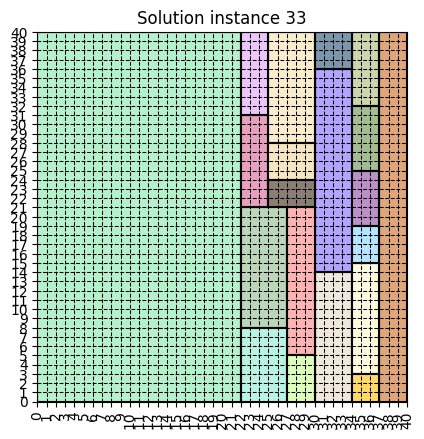


***Instance num: 34 ***

Plate width -> 15
Min h -> 40
Max h -> 56

- Attempt num -> 1
 - Tested h -> 40
Solver timeout: 300 s
Expired time for this attempt -> 17.083 s
**SAT**
Optimal solution founded in 17.083 s, h -> 40


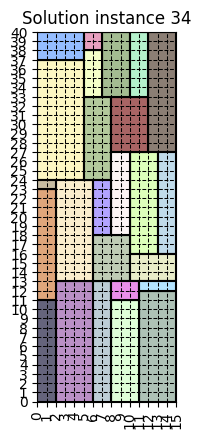


***Instance num: 35 ***

Plate width -> 15
Min h -> 40
Max h -> 65

- Attempt num -> 1
 - Tested h -> 40
Solver timeout: 300 s


In [ ]:
number_tests = 5
for i in range(number_tests):
   solve_instances(instance_num, time_limit, rotation = False, symmetry_breaking = False, verbose = False, count = i+1)
   solve_instances(instance_num, time_limit, rotation = False, symmetry_breaking = True, verbose = False, count = i+1)
   solve_instances(instance_num, time_limit, rotation = True, symmetry_breaking = False, verbose = False, count = i+1)
   solve_instances(instance_num, time_limit, rotation = True, symmetry_breaking = True, verbose = False, count = i+1)